# Image Processing

## 0 - Imports and utils

In [1]:
import depthai as dai
from depthai_sdk import toTensorResult
import numpy as np
import cv2
import time
from pathlib import Path
from matplotlib import pyplot as plt
import glob
import importlib

## 1 - Pipelines

### Save segmentation as png

Data shape: (4, 512, 896)
Values from 0.0 to 1.0
Segmentation image has int values from 0 to 255 with shape (512, 896, 3)
images saved


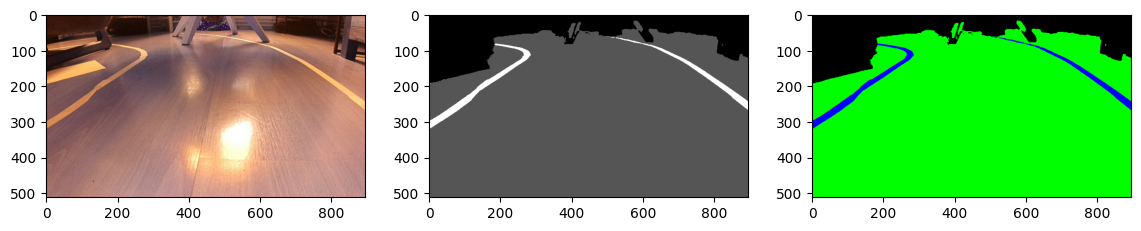

In [138]:
# Create pipeline
pipeline = dai.Pipeline()

# This might improve reducing the latency on some systems
pipeline.setXLinkChunkSize(0)

# Define sources
cam = pipeline.create(dai.node.ColorCamera)

cam.setResolution(dai.ColorCameraProperties.SensorResolution.THE_1080_P) # 1920 x 1080
cam.setInterleaved(False)
cam.setColorOrder(dai.ColorCameraProperties.ColorOrder.BGR)
cam.initialControl.setManualFocus(0) # from calibration data
cam.initialControl.setAutoWhiteBalanceMode(dai.CameraControl.AutoWhiteBalanceMode.FLUORESCENT) # CLOUDY_DAYLIGHT FLUORESCENT

cam.setFps(4) # heavily influence e2e latency

cam.setPreviewKeepAspectRatio(False)
resolution = (896, 512)
cam.setPreviewSize(resolution) # wich means cropping if aspect ratio kept
cam.setIspScale(9, 19) # "scale" sensor size, (9,19) = 910x512 ; seems very slightly faster eg. from 30.48ms to 28.83ms
# see https://docs.google.com/spreadsheets/d/153yTstShkJqsPbkPOQjsVRmM8ZO3A6sCqm7uayGF-EE/edit#gid=0

# NN
nn = pipeline.create(dai.node.NeuralNetwork)
nn.setBlobPath(BLOB_PATH)

cam.preview.link(nn.input)

# Send NN out to the host via XLink
nnXout = pipeline.create(dai.node.XLinkOut)
nnXout.setStreamName("nnXout")
nn.out.link(nnXout.input)

prevXout = pipeline.create(dai.node.XLinkOut)
prevXout.setStreamName("prevXout")
cam.preview.link(prevXout.input)

# Connect to device and start pipeline
with dai.Device(pipeline) as device:

    qNn = device.getOutputQueue("nnXout", maxSize=2, blocking=False)
    qPrev = device.getOutputQueue("prevXout", maxSize=2, blocking=False)

    diffs = np.array([])
    count = 0
    total_count = 80
    skip_count = total_count-1
    last_time = dai.Clock.now()

    # Make sure the destination path is present before starting to store the examples
    dirName = "output"
    Path(dirName).mkdir(parents=True, exist_ok=True)

    while count < total_count:
        nnData = qNn.get() # Blocking
        prevData = qPrev.get()

        if count >= skip_count:

            # see https://docs.openvino.ai/latest/omz_models_model_road_segmentation_adas_0001.html
            # and https://github.com/luxonis/depthai/blob/main/resources/nn/road-segmentation-adas-0001/handler.py
            data = np.squeeze(toTensorResult(nnData)["L0317_ReWeight_SoftMax"])
            print("Data shape: " + str(data.shape))
            print("Values from {} to {}".format(np.min(data), np.max(data)))

            # background, road, curb, mark
            classes = [0, 1, 2, 3]
            classes = np.asarray(classes, dtype=np.uint8)
            classColors = [[0, 0, 0], [0, 255, 0], [255, 0, 0], [0, 0, 255]]
            classColors = np.asarray(classColors, dtype=np.uint8)

            indices = np.argmax(data, axis=0)
            segmentation = np.take(classes, indices, axis=0)
            segmentation_colored = np.take(classColors, indices, axis=0)
            print("Segmentation image has int values from 0 to 255 with shape " + str(segmentation_colored.shape))

            frame = prevData.getCvFrame()

            now = time.time()
            cv2.imwrite(f"{dirName}/{int(now * 1000)}_frame.png", frame)
            cv2.imwrite(f"{dirName}/{int(now * 1000)}_data.png", data)
            cv2.imwrite(f"{dirName}/{int(now * 1000)}_seg.png", segmentation)
            cv2.imwrite(f"{dirName}/{int(now * 1000)}_colored.png", segmentation_colored)

            print('images saved')
        
        count += 1

fig = plt.figure(figsize=(14, 8))
(rows, columns) = (1,3)

fig.add_subplot(rows, columns, 1)
plt.imshow(frame, cmap='gray', vmin=0, vmax=255)

fig.add_subplot(rows, columns, 2)
plt.imshow(segmentation, cmap='gray', vmin=0, vmax=3)

fig.add_subplot(rows, columns, 3)
plt.imshow(segmentation_colored)

plt.show()

### Take Left Camera Image

INFO:donkeycar.parts.oak_d_camera:Starting OAK-D camera
INFO:donkeycar.parts.oak_d_camera:...warming camera
INFO:donkeycar.parts.oak_d_camera:OAK-D camera ready.
DEBUG:donkeycar.parts.oak_d_camera:Image latency: 8.21 ms, Average latency: 9.98 ms, Std: 3.80
INFO:donkeycar.parts.oak_d_camera:Stopping OAK-D camera


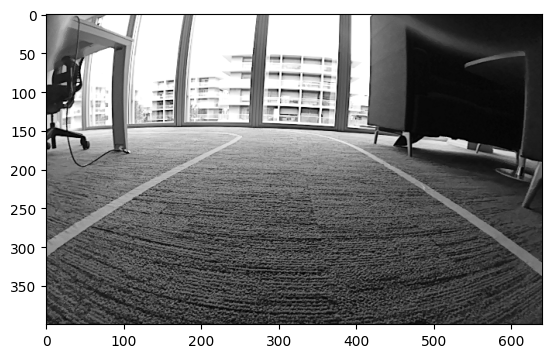

In [26]:
import donkeycar.parts.oak_d_camera as oak_d_camera
importlib.reload(oak_d_camera)

cam = oak_d_camera.OakDCamera(width=640, height=400, depth=1, framerate=30, enable_depth=False, enable_obstacle_dist=False)
time.sleep(3)
count = 0
total_count = 20

while count < total_count:
    cam.run()
    frame = cam.frame_xout
    count += 1
cam.shutdown()

plt.imshow(frame, cmap='gray', vmin=0, vmax=255)
plt.show()

In [1]:
import donkeycar.parts.lane_detection.lane_detection as ld
importlib.reload(ld) 
ld.main_from_frame(frame)

________             ______                   _________              
___  __ \_______________  /___________  __    __  ____/_____ ________
__  / / /  __ \_  __ \_  //_/  _ \_  / / /    _  /    _  __ `/_  ___/
_  /_/ // /_/ /  / / /  ,<  /  __/  /_/ /     / /___  / /_/ /_  /    
/_____/ \____//_/ /_//_/|_| \___/_\__, /      \____/  \__,_/ /_/     
                                 /____/                              

using donkey v4.4.3 ...


NameError: name 'importlib' is not defined

## 2 - Ray tracing lane finding

INFO:donkeycar.parts.lane_detection.lane_detection:LaneDetection ready


../donkeycar/parts/lane_detection/test_images/246_cam_image_array_.jpg
execution time (s) : 0.011683225631713867


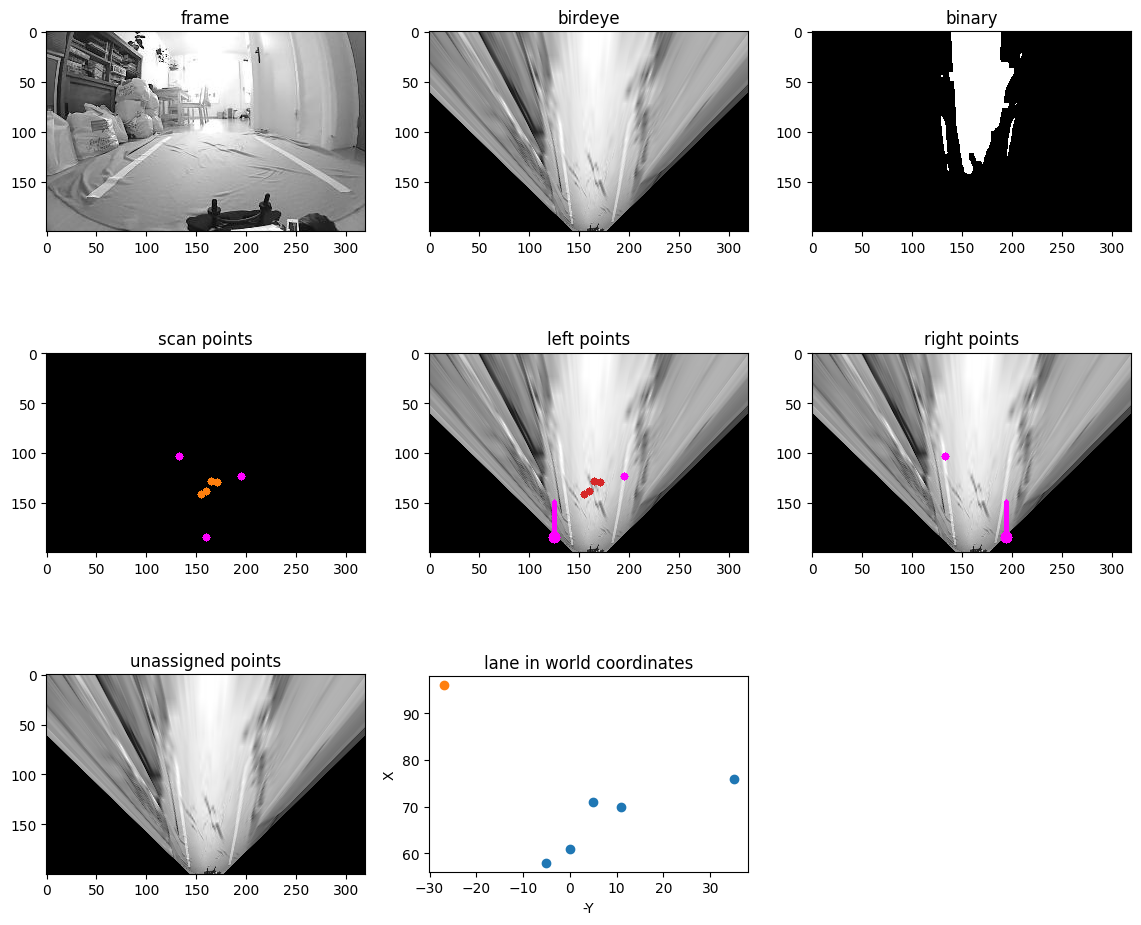

In [13]:
import donkeycar.parts.lane_detection.lane_detection as ld
importlib.reload(ld)

dir = '../donkeycar/parts/lane_detection/test_images/'
files = glob.glob(dir + '*.jpg')
files.sort()
#print(files)
number = '246' # '294b'
ld.main(dir + number + '_cam_image_array_.jpg')